# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


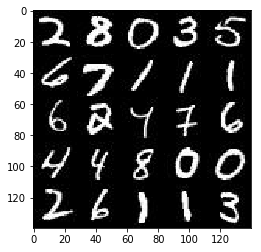

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

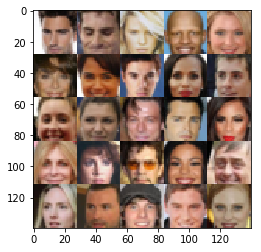

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    training = is_train
    output_dim = out_channel_dim
    alpha = 0.2
    reuse = not training
    with tf.variable_scope('generator', reuse=reuse):

        # First fully connected layer
#         x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
#         x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
#         x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        x3 = x2
#         x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=training)
#         x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.2
    output_dim = out_channel_dim

    g_model = generator(input_z, output_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):

        print('real_size = ', real_size)
        assert len(real_size) >= 3, 'len(real_size) = %i, real_size = %s' % (len(real_size), real_size)
        image_height, image_width, image_channels = real_size[-3:]
        print(image_height, image_width, image_channels)
        self.input_real, self.input_z, self.learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              image_channels)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    z_size = z_dim
    epochs = epoch_count
    print_every=10
    show_every=100
    alpha = 0.2
    figsize=(5,5)
    real_size = data_shape

#     saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)    

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                x = batch_images
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z, net.learning_rate: learning_rate})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x, net.learning_rate: learning_rate})
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    n_images = 25
                    out_channel_dim = data_shape[-1]
                    show_generator_output(sess, n_images, net.input_z, out_channel_dim, data_image_mode)
#                     gen_samples = sess.run(
#                                    generator(net.input_z, 3, training=False),
#                                    feed_dict={net.input_z: sample_z})
#                     samples.append(gen_samples)
#                     _ = view_samples(-1, samples, 6, 12, figsize=figsize)
#                     plt.show()

#         saver.save(sess, './checkpoints/generator.ckpt')

#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
    
#     return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

real_size =  (60000, 28, 28, 1)
28 28 1
Epoch 1/2... Discriminator Loss: 0.3135... Generator Loss: 1.8610
Epoch 1/2... Discriminator Loss: 1.7276... Generator Loss: 0.3693
Epoch 1/2... Discriminator Loss: 2.0971... Generator Loss: 4.4968
Epoch 1/2... Discriminator Loss: 1.3775... Generator Loss: 2.2789
Epoch 1/2... Discriminator Loss: 0.8702... Generator Loss: 1.1046
Epoch 1/2... Discriminator Loss: 0.7389... Generator Loss: 1.5765
Epoch 1/2... Discriminator Loss: 0.7975... Generator Loss: 1.0484
Epoch 1/2... Discriminator Loss: 0.7619... Generator Loss: 1.1954
Epoch 1/2... Discriminator Loss: 0.8086... Generator Loss: 0.8747
Epoch 1/2... Discriminator Loss: 0.5328... Generator Loss: 1.9838


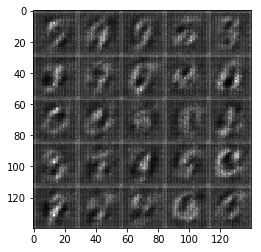

Epoch 1/2... Discriminator Loss: 0.3984... Generator Loss: 1.9204
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 0.5276
Epoch 1/2... Discriminator Loss: 0.3135... Generator Loss: 1.9704
Epoch 1/2... Discriminator Loss: 0.4492... Generator Loss: 1.1971
Epoch 1/2... Discriminator Loss: 0.3272... Generator Loss: 2.2110
Epoch 1/2... Discriminator Loss: 0.1877... Generator Loss: 2.0695
Epoch 1/2... Discriminator Loss: 0.3234... Generator Loss: 1.5205
Epoch 1/2... Discriminator Loss: 3.8618... Generator Loss: 7.2068
Epoch 1/2... Discriminator Loss: 0.6466... Generator Loss: 2.1397
Epoch 1/2... Discriminator Loss: 1.8214... Generator Loss: 5.2529


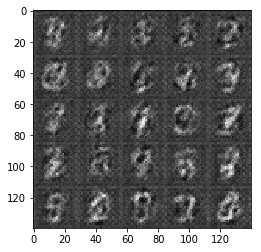

Epoch 1/2... Discriminator Loss: 0.4454... Generator Loss: 2.5293
Epoch 1/2... Discriminator Loss: 0.5424... Generator Loss: 4.6419
Epoch 1/2... Discriminator Loss: 0.1137... Generator Loss: 3.8094
Epoch 1/2... Discriminator Loss: 0.2656... Generator Loss: 2.3344
Epoch 1/2... Discriminator Loss: 0.1564... Generator Loss: 3.3195
Epoch 1/2... Discriminator Loss: 0.2599... Generator Loss: 2.0715
Epoch 1/2... Discriminator Loss: 0.7642... Generator Loss: 3.5240
Epoch 1/2... Discriminator Loss: 0.2663... Generator Loss: 1.9453
Epoch 1/2... Discriminator Loss: 0.1793... Generator Loss: 2.3998
Epoch 1/2... Discriminator Loss: 2.0771... Generator Loss: 0.1715


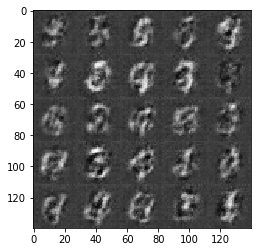

Epoch 1/2... Discriminator Loss: 0.5959... Generator Loss: 1.2454
Epoch 1/2... Discriminator Loss: 0.5576... Generator Loss: 1.1458
Epoch 1/2... Discriminator Loss: 0.2995... Generator Loss: 1.9352
Epoch 1/2... Discriminator Loss: 0.2933... Generator Loss: 1.8660
Epoch 1/2... Discriminator Loss: 0.2092... Generator Loss: 2.2463
Epoch 1/2... Discriminator Loss: 0.4427... Generator Loss: 2.7041
Epoch 1/2... Discriminator Loss: 0.3544... Generator Loss: 1.4581
Epoch 1/2... Discriminator Loss: 0.2659... Generator Loss: 1.9230
Epoch 1/2... Discriminator Loss: 0.2431... Generator Loss: 1.9058
Epoch 1/2... Discriminator Loss: 0.2346... Generator Loss: 1.9880


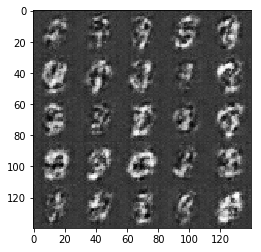

Epoch 1/2... Discriminator Loss: 0.1457... Generator Loss: 2.5851
Epoch 1/2... Discriminator Loss: 0.5161... Generator Loss: 1.0874
Epoch 1/2... Discriminator Loss: 0.3157... Generator Loss: 1.7569
Epoch 1/2... Discriminator Loss: 0.1718... Generator Loss: 2.6566
Epoch 1/2... Discriminator Loss: 0.0991... Generator Loss: 3.1602
Epoch 1/2... Discriminator Loss: 0.0969... Generator Loss: 3.4000
Epoch 2/2... Discriminator Loss: 0.0632... Generator Loss: 4.2692
Epoch 2/2... Discriminator Loss: 0.1214... Generator Loss: 3.1148
Epoch 2/2... Discriminator Loss: 0.0782... Generator Loss: 3.3294
Epoch 2/2... Discriminator Loss: 0.1262... Generator Loss: 4.5736


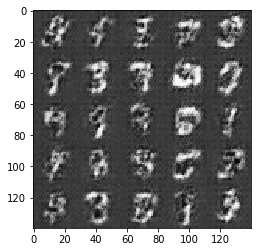

Epoch 2/2... Discriminator Loss: 0.0698... Generator Loss: 3.9760
Epoch 2/2... Discriminator Loss: 0.0575... Generator Loss: 3.8186
Epoch 2/2... Discriminator Loss: 0.2666... Generator Loss: 5.7839
Epoch 2/2... Discriminator Loss: 0.4619... Generator Loss: 2.0530
Epoch 2/2... Discriminator Loss: 0.2744... Generator Loss: 2.2418
Epoch 2/2... Discriminator Loss: 0.2147... Generator Loss: 2.5783
Epoch 2/2... Discriminator Loss: 0.2892... Generator Loss: 2.1073
Epoch 2/2... Discriminator Loss: 0.2435... Generator Loss: 2.0468
Epoch 2/2... Discriminator Loss: 0.1744... Generator Loss: 2.4120
Epoch 2/2... Discriminator Loss: 0.1302... Generator Loss: 2.6764


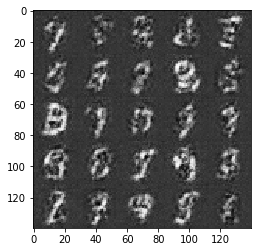

Epoch 2/2... Discriminator Loss: 0.1335... Generator Loss: 2.6306
Epoch 2/2... Discriminator Loss: 0.1132... Generator Loss: 2.8756
Epoch 2/2... Discriminator Loss: 0.1012... Generator Loss: 2.9258
Epoch 2/2... Discriminator Loss: 0.0831... Generator Loss: 3.3732
Epoch 2/2... Discriminator Loss: 0.1120... Generator Loss: 2.7611
Epoch 2/2... Discriminator Loss: 0.0813... Generator Loss: 3.1478
Epoch 2/2... Discriminator Loss: 0.0620... Generator Loss: 3.4509
Epoch 2/2... Discriminator Loss: 0.0526... Generator Loss: 3.7047
Epoch 2/2... Discriminator Loss: 0.0562... Generator Loss: 3.5246
Epoch 2/2... Discriminator Loss: 0.0628... Generator Loss: 3.4094


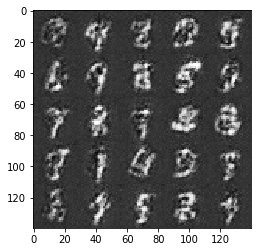

Epoch 2/2... Discriminator Loss: 0.0547... Generator Loss: 3.7812
Epoch 2/2... Discriminator Loss: 0.0528... Generator Loss: 3.6910
Epoch 2/2... Discriminator Loss: 0.0616... Generator Loss: 3.5467
Epoch 2/2... Discriminator Loss: 0.0541... Generator Loss: 3.7572
Epoch 2/2... Discriminator Loss: 0.0680... Generator Loss: 3.2641
Epoch 2/2... Discriminator Loss: 0.0387... Generator Loss: 4.0517
Epoch 2/2... Discriminator Loss: 0.0378... Generator Loss: 3.9401
Epoch 2/2... Discriminator Loss: 0.0306... Generator Loss: 4.6058
Epoch 2/2... Discriminator Loss: 0.0335... Generator Loss: 4.1769
Epoch 2/2... Discriminator Loss: 0.0302... Generator Loss: 4.7858


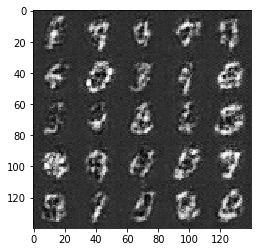

Epoch 2/2... Discriminator Loss: 0.0510... Generator Loss: 3.8235
Epoch 2/2... Discriminator Loss: 0.0463... Generator Loss: 4.6447
Epoch 2/2... Discriminator Loss: 0.0264... Generator Loss: 4.1981
Epoch 2/2... Discriminator Loss: 1.5671... Generator Loss: 0.4317
Epoch 2/2... Discriminator Loss: 0.4375... Generator Loss: 1.8757
Epoch 2/2... Discriminator Loss: 0.3165... Generator Loss: 1.6656
Epoch 2/2... Discriminator Loss: 0.1260... Generator Loss: 2.6144
Epoch 2/2... Discriminator Loss: 0.1064... Generator Loss: 2.8473
Epoch 2/2... Discriminator Loss: 0.0850... Generator Loss: 3.3740
Epoch 2/2... Discriminator Loss: 0.0607... Generator Loss: 3.3185


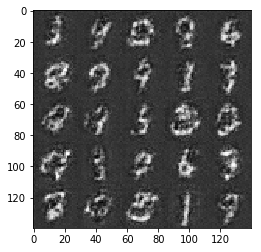

Epoch 2/2... Discriminator Loss: 0.0573... Generator Loss: 3.4800
Epoch 2/2... Discriminator Loss: 0.0742... Generator Loss: 3.2693
Epoch 2/2... Discriminator Loss: 0.0521... Generator Loss: 3.6294


In [26]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

real_size =  (202599, 28, 28, 3)
28 28 3
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 1.2011
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 2.5688
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 4.4698
Epoch 1/1... Discriminator Loss: 0.2363... Generator Loss: 4.2018
Epoch 1/1... Discriminator Loss: 0.1585... Generator Loss: 2.4710


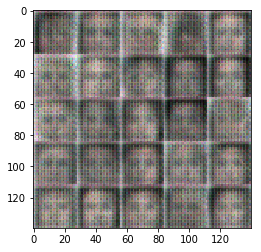

Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 0.2239... Generator Loss: 4.8125
Epoch 1/1... Discriminator Loss: 2.3542... Generator Loss: 0.2062
Epoch 1/1... Discriminator Loss: 0.5115... Generator Loss: 1.4378
Epoch 1/1... Discriminator Loss: 0.2664... Generator Loss: 5.0509
Epoch 1/1... Discriminator Loss: 0.0789... Generator Loss: 3.7388
Epoch 1/1... Discriminator Loss: 0.3130... Generator Loss: 1.9972
Epoch 1/1... Discriminator Loss: 0.1056... Generator Loss: 12.9466
Epoch 1/1... Discriminator Loss: 0.4910... Generator Loss: 10.1734
Epoch 1/1... Discriminator Loss: 0.1338... Generator Loss: 7.3019


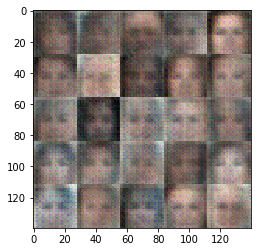

Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 0.0131... Generator Loss: 7.1296
Epoch 1/1... Discriminator Loss: 0.0877... Generator Loss: 13.5817
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 15.2929
Epoch 1/1... Discriminator Loss: 3.9122... Generator Loss: 0.0283
Epoch 1/1... Discriminator Loss: 2.7872... Generator Loss: 0.1255
Epoch 1/1... Discriminator Loss: 1.9070... Generator Loss: 14.3051
Epoch 1/1... Discriminator Loss: 0.2378... Generator Loss: 12.2455
Epoch 1/1... Discriminator Loss: 3.0651... Generator Loss: 0.0558
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.4112


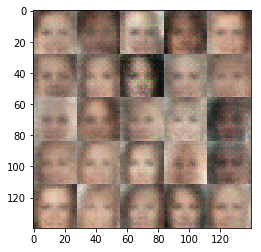

Epoch 1/1... Discriminator Loss: 0.0303... Generator Loss: 11.2635
Epoch 1/1... Discriminator Loss: 0.2648... Generator Loss: 7.6832
Epoch 1/1... Discriminator Loss: 1.7500... Generator Loss: 7.8114
Epoch 1/1... Discriminator Loss: 0.0328... Generator Loss: 9.5026
Epoch 1/1... Discriminator Loss: 0.0485... Generator Loss: 5.0764
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 10.3256
Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 6.0853
Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 3.9806
Epoch 1/1... Discriminator Loss: 0.0475... Generator Loss: 15.8922
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 1.8267


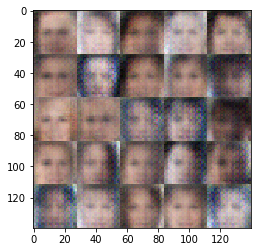

Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 9.5873
Epoch 1/1... Discriminator Loss: 0.0361... Generator Loss: 4.3466
Epoch 1/1... Discriminator Loss: 0.0916... Generator Loss: 3.0233
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 12.8207
Epoch 1/1... Discriminator Loss: 0.0252... Generator Loss: 5.1629
Epoch 1/1... Discriminator Loss: 0.2015... Generator Loss: 2.0573
Epoch 1/1... Discriminator Loss: 0.0364... Generator Loss: 4.2781
Epoch 1/1... Discriminator Loss: 0.0360... Generator Loss: 6.5705
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 6.9147
Epoch 1/1... Discriminator Loss: 2.3761... Generator Loss: 4.5172


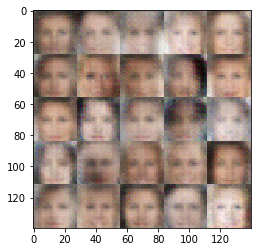

Epoch 1/1... Discriminator Loss: 0.6627... Generator Loss: 4.3135
Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 12.2003
Epoch 1/1... Discriminator Loss: 0.2415... Generator Loss: 5.4290
Epoch 1/1... Discriminator Loss: 0.1006... Generator Loss: 5.5809
Epoch 1/1... Discriminator Loss: 0.0167... Generator Loss: 9.3225
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 0.0311... Generator Loss: 4.6059
Epoch 1/1... Discriminator Loss: 0.2817... Generator Loss: 1.8327
Epoch 1/1... Discriminator Loss: 0.0283... Generator Loss: 7.7936
Epoch 1/1... Discriminator Loss: 0.0598... Generator Loss: 3.5071


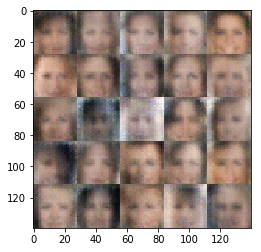

Epoch 1/1... Discriminator Loss: 0.2537... Generator Loss: 1.8577
Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 7.9237
Epoch 1/1... Discriminator Loss: 0.0345... Generator Loss: 5.3296
Epoch 1/1... Discriminator Loss: 0.2109... Generator Loss: 2.1088
Epoch 1/1... Discriminator Loss: 0.0332... Generator Loss: 5.4864
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 7.1701
Epoch 1/1... Discriminator Loss: 0.0188... Generator Loss: 8.2916
Epoch 1/1... Discriminator Loss: 0.0694... Generator Loss: 6.3797
Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 5.4996
Epoch 1/1... Discriminator Loss: 0.0150... Generator Loss: 9.0078


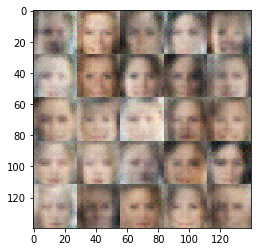

Epoch 1/1... Discriminator Loss: 0.0143... Generator Loss: 5.1965
Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 10.0883
Epoch 1/1... Discriminator Loss: 0.0268... Generator Loss: 7.6456
Epoch 1/1... Discriminator Loss: 0.2622... Generator Loss: 1.8652
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 13.8728
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 7.5160
Epoch 1/1... Discriminator Loss: 0.0454... Generator Loss: 11.4540
Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 6.4882
Epoch 1/1... Discriminator Loss: 0.0057... Generator Loss: 7.7938
Epoch 1/1... Discriminator Loss: 0.0191... Generator Loss: 4.5650


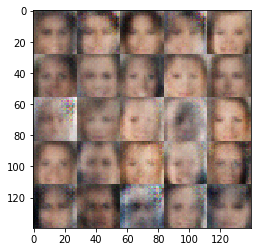

Epoch 1/1... Discriminator Loss: 0.0917... Generator Loss: 11.0366
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 12.2923
Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 10.2174
Epoch 1/1... Discriminator Loss: 0.0046... Generator Loss: 9.4600
Epoch 1/1... Discriminator Loss: 0.0184... Generator Loss: 10.8792
Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 6.8570
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 8.6473
Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 15.1581
Epoch 1/1... Discriminator Loss: 0.0045... Generator Loss: 10.3853


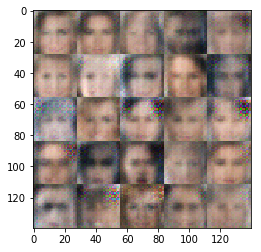

Epoch 1/1... Discriminator Loss: 0.1761... Generator Loss: 2.1465
Epoch 1/1... Discriminator Loss: 0.0074... Generator Loss: 14.0803
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 10.1352
Epoch 1/1... Discriminator Loss: 0.0512... Generator Loss: 3.9772
Epoch 1/1... Discriminator Loss: 0.0060... Generator Loss: 9.2914
Epoch 1/1... Discriminator Loss: 0.0054... Generator Loss: 13.6874
Epoch 1/1... Discriminator Loss: 0.0039... Generator Loss: 10.8470
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 7.9523
Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 9.0552
Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 10.3659


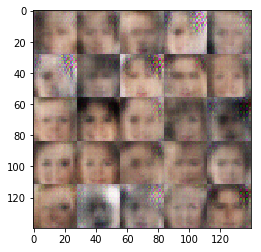

Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 6.6629
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 11.2475
Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 8.3137
Epoch 1/1... Discriminator Loss: 0.0176... Generator Loss: 5.1903
Epoch 1/1... Discriminator Loss: 0.0065... Generator Loss: 8.0914
Epoch 1/1... Discriminator Loss: 0.0089... Generator Loss: 9.1733
Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 7.8569
Epoch 1/1... Discriminator Loss: 0.0239... Generator Loss: 13.8848
Epoch 1/1... Discriminator Loss: 0.0057... Generator Loss: 8.5639
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 13.3218


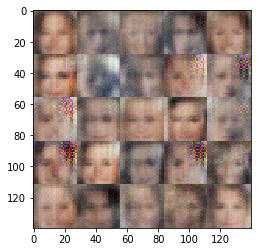

Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 8.8573
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 7.1032
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 8.6962
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 9.0981
Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 10.7696
Epoch 1/1... Discriminator Loss: 0.0064... Generator Loss: 6.7966
Epoch 1/1... Discriminator Loss: 0.0128... Generator Loss: 8.2653
Epoch 1/1... Discriminator Loss: 0.0215... Generator Loss: 4.8435
Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 9.6719
Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 8.6777


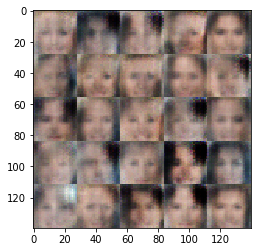

Epoch 1/1... Discriminator Loss: 0.0059... Generator Loss: 11.1634
Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 7.0843
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 12.1329
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 1.7640
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 3.9370
Epoch 1/1... Discriminator Loss: 0.0470... Generator Loss: 5.1454
Epoch 1/1... Discriminator Loss: 0.4705... Generator Loss: 5.2609
Epoch 1/1... Discriminator Loss: 0.0326... Generator Loss: 4.7637
Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 6.5240
Epoch 1/1... Discriminator Loss: 0.0245... Generator Loss: 6.6811


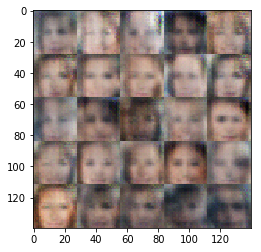

Epoch 1/1... Discriminator Loss: 0.0181... Generator Loss: 6.6534
Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 6.9997
Epoch 1/1... Discriminator Loss: 0.0536... Generator Loss: 4.3826
Epoch 1/1... Discriminator Loss: 0.0339... Generator Loss: 11.8061
Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 7.1704
Epoch 1/1... Discriminator Loss: 0.0089... Generator Loss: 7.7334
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 8.9470
Epoch 1/1... Discriminator Loss: 0.0367... Generator Loss: 4.8539
Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 11.9794
Epoch 1/1... Discriminator Loss: 0.0167... Generator Loss: 4.9893


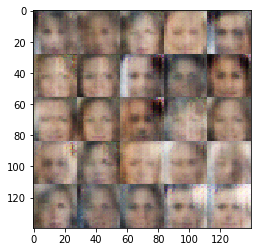

Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 5.7110
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 10.2189
Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 6.5325
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 10.1831
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 8.6602
Epoch 1/1... Discriminator Loss: 0.0087... Generator Loss: 8.6403
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 10.1216
Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 10.9920
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 9.0179
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 9.4079


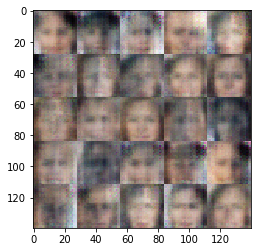

Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 10.5448
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 11.9593
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 6.8614
Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 10.4523
Epoch 1/1... Discriminator Loss: 0.0023... Generator Loss: 10.8073
Epoch 1/1... Discriminator Loss: 0.1957... Generator Loss: 12.6172
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 10.9979
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 12.0267


In [29]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.